# Семинар 2. Логистическая регрессия. Классификация полносвязной сетью на MNIST 🦾

# Сегодня на занятии:
- Логистическая регрессия: повторение и закрепление лекции
- Логистическая регрессия. Пример
- Полносвязная нейронная сеть
- Классификация на датасете MNIST
- Обратное распространение ошибки

# Логистическая регрессия: повторение и закрепление лекции


Предположим, наши данные можно разделить прямой (рассмотрим простой случай). Мы хотим обучить линейную модель, которая будет своими параметрами описывать разделяющую плоскость между классами. И тогда те точки, которые окажутся сверху, будут принадлежать классу 1, а те, что снизу - классу 0:

$$y = sign(Wx)$$

![](images/0.png)

*Разделяющая гиперплоскость между классами*

Исходное уравнение:

$$y = Wx$$

Преобразуем левую часть, чтобы получить функцию вероятности, которая будет давать число из $ℝ$:

$$ln\frac{p}{1-p} = Wx$$

Величина $ln\frac{p}{1-p}$ еще назвается логитом

Сигмоида:

$$σ(y) = \frac{1}{1+e^{-y}}$$

В итоге формула для вероятности бинарной классификации:

$$p(x) = \frac{1}{1+e^{-Wx}} = σ(Wx)$$

Как теперь нам научиться оптимизировать веса $W$? Применим метод максимального правдоподобия для распределения Бернулли:

![](images/1.png)

Чтобы получить функцию потерь, которую надо минимизировать, добавим знак минус к функции правдоподобия (которую максимизируют):

$$L(W, x, y) = - ∑_i(y_i log(\sigma(Wx_i)) + (1-y_i) log(1 - \sigma(Wx_i)))$$

По-другому можно записать так:

$$L(W, x, y) = - ∑_i(y_i log(q_i) + (1-y_i) log(1 - q_i)),$$ где $q_i$ - это предсказание нашей сети

В отличие от линейной регрессии, у нас нет явной формулы для решения. Поэтому будем использовать просто градиентный спуск. Формула для градиента:

$$\nabla_{w} L(W, x, y) = - ∑_i x_i(y_i - \sigma(Wx_i))$$

## Многоклассовая классификация

В задаче классификации на $K$ классов будем учить $K-1$ классификаторов предсказывать отношение вероятности $i$-го класса к последнему:

$$ln(\frac{p_1}{p_k}) = W_1x$$
$$...$$
$$ln(\frac{p_{k-1}}{p_k}) = W_{k-1}x$$

и получаем

$$p_i = \frac{e^{W_ix}}{∑_je^{W_jx}}$$

Вывод функции потерь из метода максимального правдоподобия:

$$L(W, y, x) = p(y|x;W) = ∏_{i=1}^Np_{1i}^{y_{1i}}...p_{ki}^{y_{ki}}$$
$$L(W, y, x) → max_W$$
$$ln(L(W, y, x)) → max_W$$
$$-ln(L(W, y, x)) → min_W$$

$$-∑_{i=1}^{N}y_{1i}ln(p_{1i}) + ... + y_{ki}ln(p_{ki}) → min_W$$
$$-∑_{i=1}^{N}∑_{c=1}^{K}y_{ci}ln(p_{ci}) → min_W$$

$i$-индекс в выборке, $c$-индекс класса

# Логистическая регрессия. Пример

Нагенерируем данные случайным образом:

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification, make_blobs, make_moons
from sklearn.linear_model import LogisticRegression

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

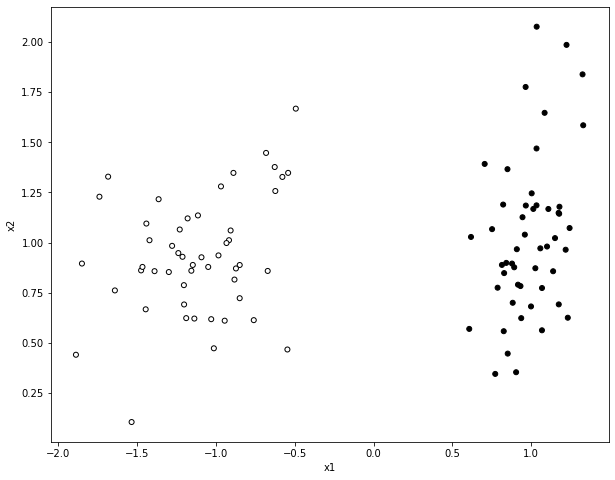

In [7]:
# X, y = make_blobs(n_features=2, centers=2, random_state=42)  # Y - это лейблы
X, y = make_classification(
    n_features=2,
    n_redundant=0,
    n_informative=2,
    random_state=1, 
    n_clusters_per_class=1,
)
# X, y = make_moons(n_samples=100, noise=0.24)

plt.scatter(X[:, 0], X[:, 1], marker="o", c=y, s=25, edgecolor="k")
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

На этот раз воспользуемся готовым решением из библиотеки `sklearn`. Попробуем запустить логистическую регрессию и подогнать наши данные, а потом визуализировать разделяющую прямую для разных порогов

In [8]:
print(X.shape, y.shape)
print(X[:4], y[:4], sep='\n')

(100, 2) (100,)
[[-1.04948638  0.8786438 ]
 [ 0.8780991   0.89551051]
 [ 0.95928819  1.03967316]
 [-1.18013412  1.12062155]]
[1 0 0 1]


In [9]:
model= LogisticRegression()
model.fit(X, y)

LogisticRegression()

In [10]:
print(model.coef_)  # коэффициенты перед фичой 1 и фичой 2
print(model.intercept_)  # свободный член в линейной части уравнения logit(p) = Wx + b 

[[-3.36656909  0.12308678]]
[-0.13931403]


Формула логистической регрессии:

$logit(p) = w_1x_1 + w_2x_2 + w_0$

- Установливаем порог на выход регрессии (начиная с какого значения $p$ мы будем считать, что получили объект класса 1)
- Вычисляем $logit(p)$ для этого $p$
- Выражаем $x_2$ через $x_1$ и получаем уравнение разделяющей прямой

In [11]:
def plot_dots_and_boundary(X, w, b, p_thr=0.5):
    # X --> фичи
    # w --> веса
    # b --> сдвиги
    
    logit = np.log2(p_thr) - np.log2(1 - p_thr)
    w1, w2 = w
    x1 = X[:, 0]
    x2 = (logit - b - w1 * x1) / w2

    # рисуем исходные точки
    plt.scatter(X[:, 0], X[:, 1], marker="o", c=y, s=25, edgecolor="k")
    
    # рисуем прямую
    plt.plot(x1, x2, 'y-')
    
    plt.xlim([min(X[:,0])-3, max(X[:,0])+3])
    plt.ylim([min(X[:,1])-3, max(X[:,1])+3])
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.title('Decision Boundary')
    plt.show()

In [12]:
w = model.coef_[0]
b = model.intercept_

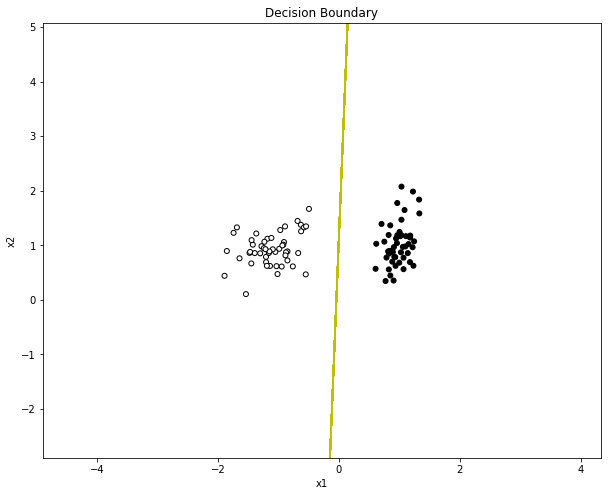

In [13]:
plot_dots_and_boundary(X, w, b, p_thr=0.5)

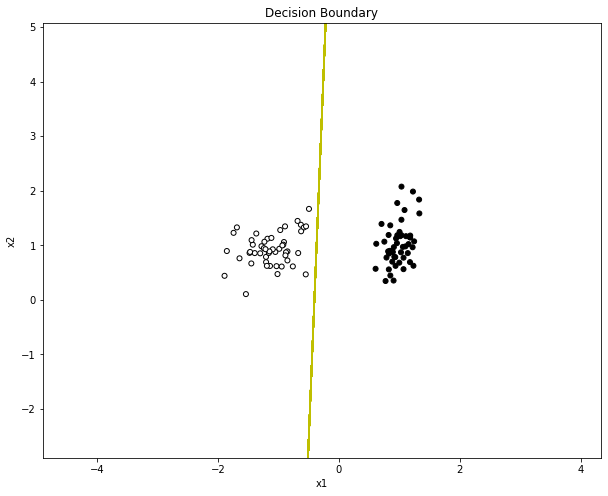

In [14]:
plot_dots_and_boundary(X, w, b, p_thr=0.7)

# Полносвязная нейронная сеть

**Нейронная сеть как ансамбль линейных классификаторов**

Построим цепочку из линейных классификаторов, каждый следующий будет получать выход предыдущего - $y = σ(Wx)$ - на вход. С каждым слоем мы как бы переводим данные в некоторое скрытое пространство и делаем в нем классификацию

Рассмотрим на примере  полносвязной (fully-connected) нейронной сети. Но сначала о том, что вообще такое полносвязная сеть:

![](images/2.png)

*Полносвязный слой. В слое с N входами и M выходами NM весов*

Полносвязная сеть состоит из полносвязных слоев и функций активаций между слоями:

![](images/3.png)

*Полносвязная сеть*

**Вопрос на подумать:** зачем нужны функции активации?

### Популярные функции активации:
![](images/4.png)

*Функции активации*

Рецепт такой: берем полносвязные слои, добавляем между ними нелинейности. В самом конце сети выбираем сигмоиду (если задача бинарной классификации) или софтмакс (если классификация на много классов)

# Классификация на датасете MNIST

Создадим и обучим первую нейронную сетку. Для этого будем пользоваться фреймворком [PyTorch](https://pytorch.org/)

In [15]:
from typing import Tuple
from random import randrange

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

import matplotlib.pyplot as plt
from tqdm import tqdm

## Создание сети
Создадим полносвязную нейронную сеть для задачи классификации рукописных цифр на датасете MNIST.

Нейронная сеть будет состоять из 3-х линейных полносвязных слоев с функцией активации `ReLU`.

In [17]:
class FullyConnectedNetwork(nn.Module):  # https://pytorch.org/docs/stable/generated/torch.nn.Module.html
    def __init__(
        self,
        img_size: Tuple[int, int, int] = (1, 28, 28),  # (кол-во каналов, высота px, ширина px)
        num_classes: int = 10,
    ):
        super().__init__()
        # Линейный слой в качестве входа принимает вектор:
        # https://pytorch.org/docs/stable/generated/torch.nn.Linear.html
        #
        # Является умножением матрицы-весов на входной вектор признаков:
        # Почему x * A^T + b, а не A^T * x + b?
        input_features = img_size[0] * img_size[1] * img_size[2]
        
        self.fc1 = nn.Linear(input_features, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, num_classes)
        
    def forward(self, x: torch.Tensor):
        # x - имеет размерность [batch_size, *], в нашем случае [batch_size, input_features].
        x = self.fc1(x)
        x = F.relu(x)
        
        x = self.fc2(x)
        x = F.relu(x)
        
        x = self.fc3(x)
        
        return x

In [18]:
model = FullyConnectedNetwork()

In [19]:
[(name, parameter.shape) for name, parameter in model.named_parameters()]

[('fc1.weight', torch.Size([128, 784])),
 ('fc1.bias', torch.Size([128])),
 ('fc2.weight', torch.Size([64, 128])),
 ('fc2.bias', torch.Size([64])),
 ('fc3.weight', torch.Size([10, 64])),
 ('fc3.bias', torch.Size([10]))]

## Сохранение/загрузка параметров модели

Параметры, определяющие модель, можно сохранить и загрузить.

Это удобно для сохранения промежуточных результатов и последующего деплоя модели.

In [20]:
model.state_dict()  # Ключ - имя параметра, значение - тензор

OrderedDict([('fc1.weight',
              tensor([[-5.6051e-03, -1.5080e-02, -4.6414e-03,  ..., -1.6608e-02,
                       -1.0607e-02,  2.7112e-02],
                      [ 3.2475e-02,  1.2457e-02, -3.1113e-02,  ..., -7.5096e-03,
                       -4.1774e-05, -1.5684e-02],
                      [ 7.1857e-03, -1.9259e-02, -2.9485e-02,  ...,  5.8410e-03,
                       -2.7499e-02,  2.8769e-02],
                      ...,
                      [-1.7274e-02,  3.2343e-02, -1.6352e-02,  ..., -9.5111e-03,
                       -5.1558e-03,  1.8290e-02],
                      [-3.0593e-02, -3.4022e-02, -3.0560e-02,  ...,  2.5302e-03,
                       -2.3016e-02,  5.0888e-03],
                      [ 2.2595e-02,  9.9620e-03,  1.9848e-02,  ..., -2.7092e-02,
                        1.9140e-03, -3.1049e-02]])),
             ('fc1.bias',
              tensor([-7.7866e-03, -2.5260e-02,  1.6824e-02,  1.4825e-02, -1.0084e-02,
                      -4.9528e-03,  1.2119e

In [21]:
torch.save(  # https://pytorch.org/tutorials/beginner/saving_loading_models.html
    obj=model.state_dict(),
    f='weights.pt',
)

In [23]:
loaded_state_dict = torch.load('weights.pt')
loaded_state_dict

OrderedDict([('fc1.weight',
              tensor([[-5.6051e-03, -1.5080e-02, -4.6414e-03,  ..., -1.6608e-02,
                       -1.0607e-02,  2.7112e-02],
                      [ 3.2475e-02,  1.2457e-02, -3.1113e-02,  ..., -7.5096e-03,
                       -4.1774e-05, -1.5684e-02],
                      [ 7.1857e-03, -1.9259e-02, -2.9485e-02,  ...,  5.8410e-03,
                       -2.7499e-02,  2.8769e-02],
                      ...,
                      [-1.7274e-02,  3.2343e-02, -1.6352e-02,  ..., -9.5111e-03,
                       -5.1558e-03,  1.8290e-02],
                      [-3.0593e-02, -3.4022e-02, -3.0560e-02,  ...,  2.5302e-03,
                       -2.3016e-02,  5.0888e-03],
                      [ 2.2595e-02,  9.9620e-03,  1.9848e-02,  ..., -2.7092e-02,
                        1.9140e-03, -3.1049e-02]])),
             ('fc1.bias',
              tensor([-7.7866e-03, -2.5260e-02,  1.6824e-02,  1.4825e-02, -1.0084e-02,
                      -4.9528e-03,  1.2119e

In [24]:
model.load_state_dict(loaded_state_dict)  # Загрузили в модель веса

<All keys matched successfully>

## Подготовка данных

In [26]:
# Обработка входного изображения:
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),  # (0 - 1)
    torchvision.transforms.Normalize(  # (-1, 1)
        mean=[0.5],
        std=[0.5],
    ),
])

In [27]:
# В PyTorch есть 2 основных класса для работы с тренировочными данными:
#
# 1. Dataset: https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset
# Загружает и обрабатывает данные.
train_dataset = torchvision.datasets.MNIST(  # MNIST - база изображений рукописных цифр.
    root='datasets',
    download=True,
    train=True,
    transform=transform,
)

# 2. Dataloader: https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader
# Производит пакетный (batch) поток данных.
train_dataloader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=256,
    shuffle=True,
    num_workers=4,
)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting datasets/MNIST/raw/train-images-idx3-ubyte.gz to datasets/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting datasets/MNIST/raw/train-labels-idx1-ubyte.gz to datasets/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to datasets/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to datasets/MNIST/raw



/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [28]:
valid_dataset = torchvision.datasets.MNIST(
    root='datasets',
    download=True,
    train=False,
    transform=transform,
)

valid_dataloader = torch.utils.data.DataLoader(
    dataset=valid_dataset,
    batch_size=256,
    shuffle=True,
    num_workers=4,
)

In [29]:
batch, _ = next(iter(train_dataloader))

In [30]:
batch.shape

torch.Size([256, 1, 28, 28])

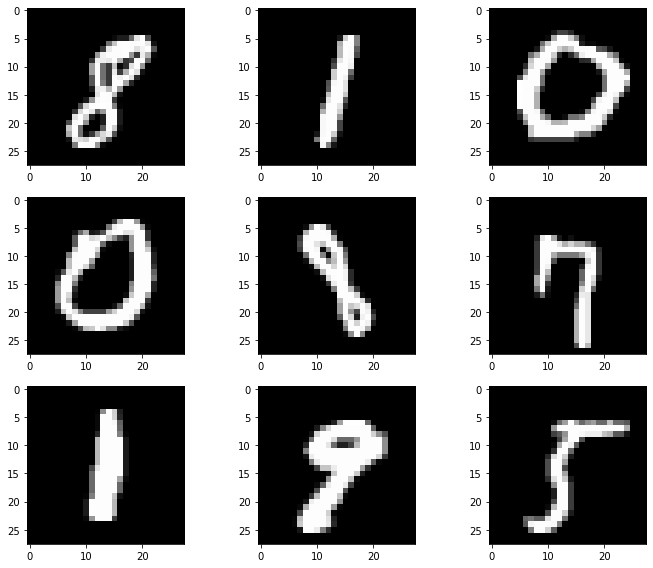

In [31]:
figure = plt.figure()

for index in range(9):
    plt.subplot(3, 3, index + 1)
    plt.tight_layout()
    plt.imshow(batch[index][0], cmap='gray', interpolation='none')

## Обучение

In [ ]:
criterion = nn.CrossEntropyLoss()  # https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html

optimizer = torch.optim.SGD(  # https://pytorch.org/docs/stable/generated/torch.optim.SGD.html
    params=model.parameters(),  # Параметры, которые будут обучаться в процессе тренировки сети
    lr=0.01,
    momentum=0.9,
)


def train_step() -> float:
    model.train()
    
    running_loss = 0.
    for images, labels in train_dataloader:
        images = images.cuda()
        labels = labels.cuda()
        images = images.view(images.shape[0], -1)  # [256, 1, 28, 28] -> [256, 1 * 28 * 28]
        
        # Удаляем накопленные ранее градиенты.
        # parameter.grad = 0
        optimizer.zero_grad()
        
        # Делаем проход (forward pass).
        # Состояние модели `train` обеспечивает сохранение промежуточных результатов вычислений.
        # Эти сохраненные значения будут использованы ниже для вычисления градиента функции потерь.
        output = model(images)
        
        # Вычисляем функцию потерь на основе предсказания модели.
        loss = criterion(output, labels)

        # Вычисляем градиент: направление, в котором функция потерь возрастает максимально быстро.
        # parameter.grad += dloss / dparameter
        loss.backward()

        # parameter += -lr * parameter.grad
        # 
        # PyTorch SGD:
        # velocity = momentum * velocity + parameter.grad
        # parameter += - lr * velocity
        optimizer.step()
        
        # Накапливаем статистику.
        running_loss += loss
    
    # Контекстный менеджер `torch.no_grad` позволяет отключить вычисление градиентов.
    # Вычисления, в которые входят обучаемые параметры, не имеющие отношения к сети повлияют на процесс обучения,
    # если для них будут накапливаться градиенты.
    # Экономия памяти.
    with torch.no_grad():
        train_loss = running_loss / len(train_dataloader)
    return train_loss.item()


def valid_step() -> Tuple[float, float]:
    model.eval()

    correct_total = 0.
    running_loss = 0.
    with torch.no_grad():
        for images, labels in valid_dataloader:
            images = images.cuda()
            labels = labels.cuda()
            images = images.view(images.shape[0], -1)

            output = model(images)
            
            prediction = output.max(  # [bs, num_classes] -> [bs, 1]
                dim=1,
                keepdim=True,
            )[1] # # .argmax(dim=1)
            correct_total += prediction.eq(labels.view_as(prediction)).sum()
            
            loss = criterion(output, labels)
            running_loss += loss
        
    valid_loss = running_loss / len(valid_dataloader)
    accuracy = correct_total / len(valid_dataloader.dataset)
    return valid_loss.item(), accuracy.item()

In [ ]:
train_losses = []
valid_losses = []
valid_accs = []

In [ ]:
epochs = 50
model.cuda()  # model.to('cuda:0')

for _ in (pbar := tqdm(range(epochs))):
    train_loss = train_step()
    valid_loss, valid_acc = valid_step()
    
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    valid_accs.append(valid_acc)
    
    pbar.set_description(f'Avg. train/valid loss: {train_loss:.4f}/{valid_loss:.4f}')

Avg. train/valid loss: 0.0057/0.0752: 100%|██████████| 50/50 [12:11<00:00, 14.62s/it]


Text(0, 0.5, 'Loss')

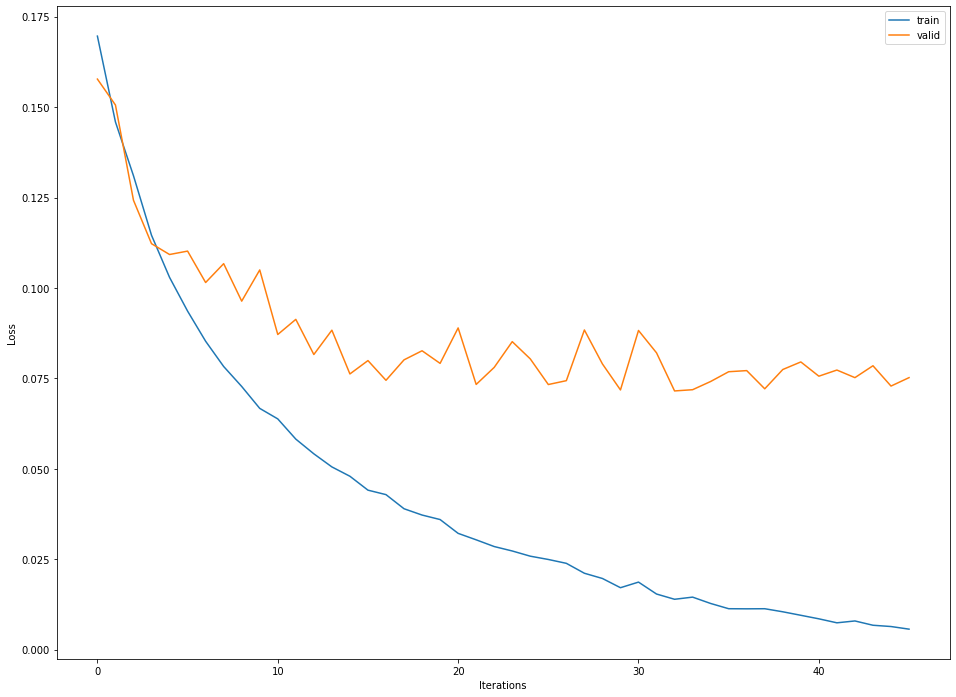

In [ ]:
fig = plt.figure(figsize=(16, 12))

plt.plot(train_losses[4:], label='train')
plt.plot(valid_losses[4:], label='valid')
plt.legend()
plt.xlabel('Iterations')
plt.ylabel('Loss')

Text(0, 0.5, 'Accuracy')

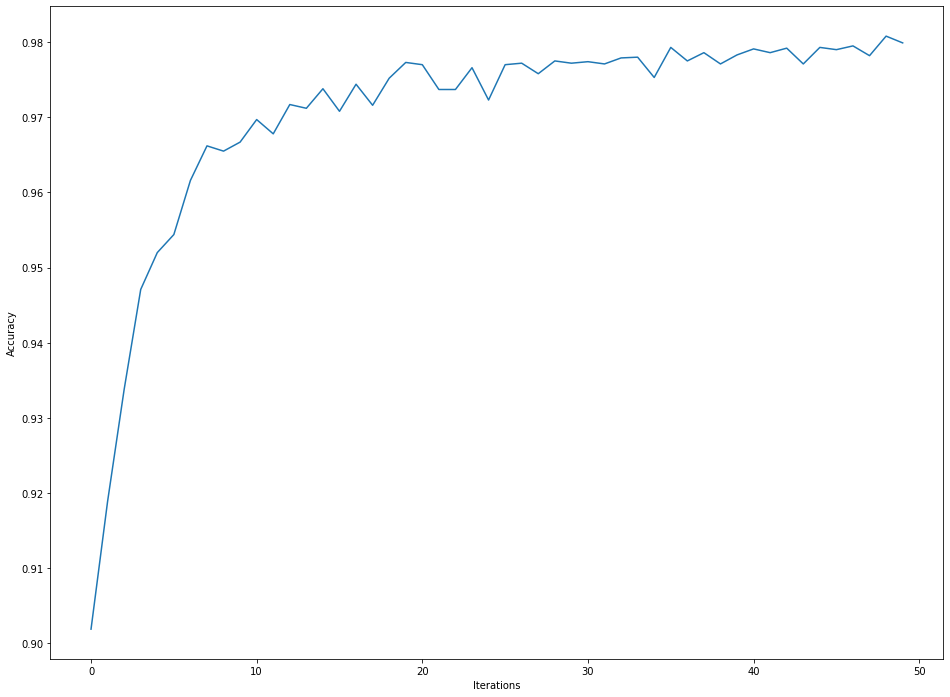

In [ ]:
fig = plt.figure(figsize=(16, 12))

plt.plot(valid_accs)
plt.xlabel('Iterations')
plt.ylabel('Accuracy')

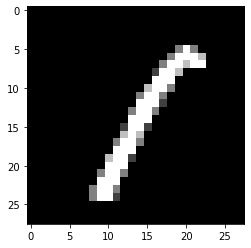

In [ ]:
batch, _ = next(iter(train_dataloader))
sample = batch[randrange(0, 255)]
plt.imshow(sample[0], cmap='gray', interpolation='none')

In [ ]:
model.cpu()

FullyConnectedNetwork(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)

In [ ]:
prediction = model(sample.view(sample.shape[0], -1))

In [ ]:
prediction

tensor([[-7.2245, 16.2220, -2.9094, -8.4230,  6.0215, -4.0992,  0.0399,  4.2468,
          1.5978, -9.6569]], grad_fn=<AddmmBackward0>)

In [ ]:
# .argmax(dim=1)
prediction.max(
    dim=1,
    keepdim=True,
)[1].item()

1

# Обратное распространение ошибки

Как считать градиент функции потерь (лосса) по весам?

![](images/5.png)

*Прямой проход*

![](images/6.png)

*Обратный проход*

Во время обратного распространения ошибки алгоритм считает градиенты лосса по входам слоев (начиная с конца). Чтобы посчитать градиент по предыдущему слою, нужно домножить градиент для текущего слоя на соответствующую частную производную.

На примере:

![](images/7.png)

*Пример вычисления градиентов*